A grid is a collection of thread blocks, and a thread block is a collection of threads.

Threads are executed on the GPU in groups called warps, each containing 32 threads.

A block is divided into one or more warps, and warps are the actual execution units scheduled on a Streaming Multiprocessor (SM).

Block size does NOT have to be a multiple of 32, but choosing a multiple of 32 avoids partially filled warps and leads to better performance.

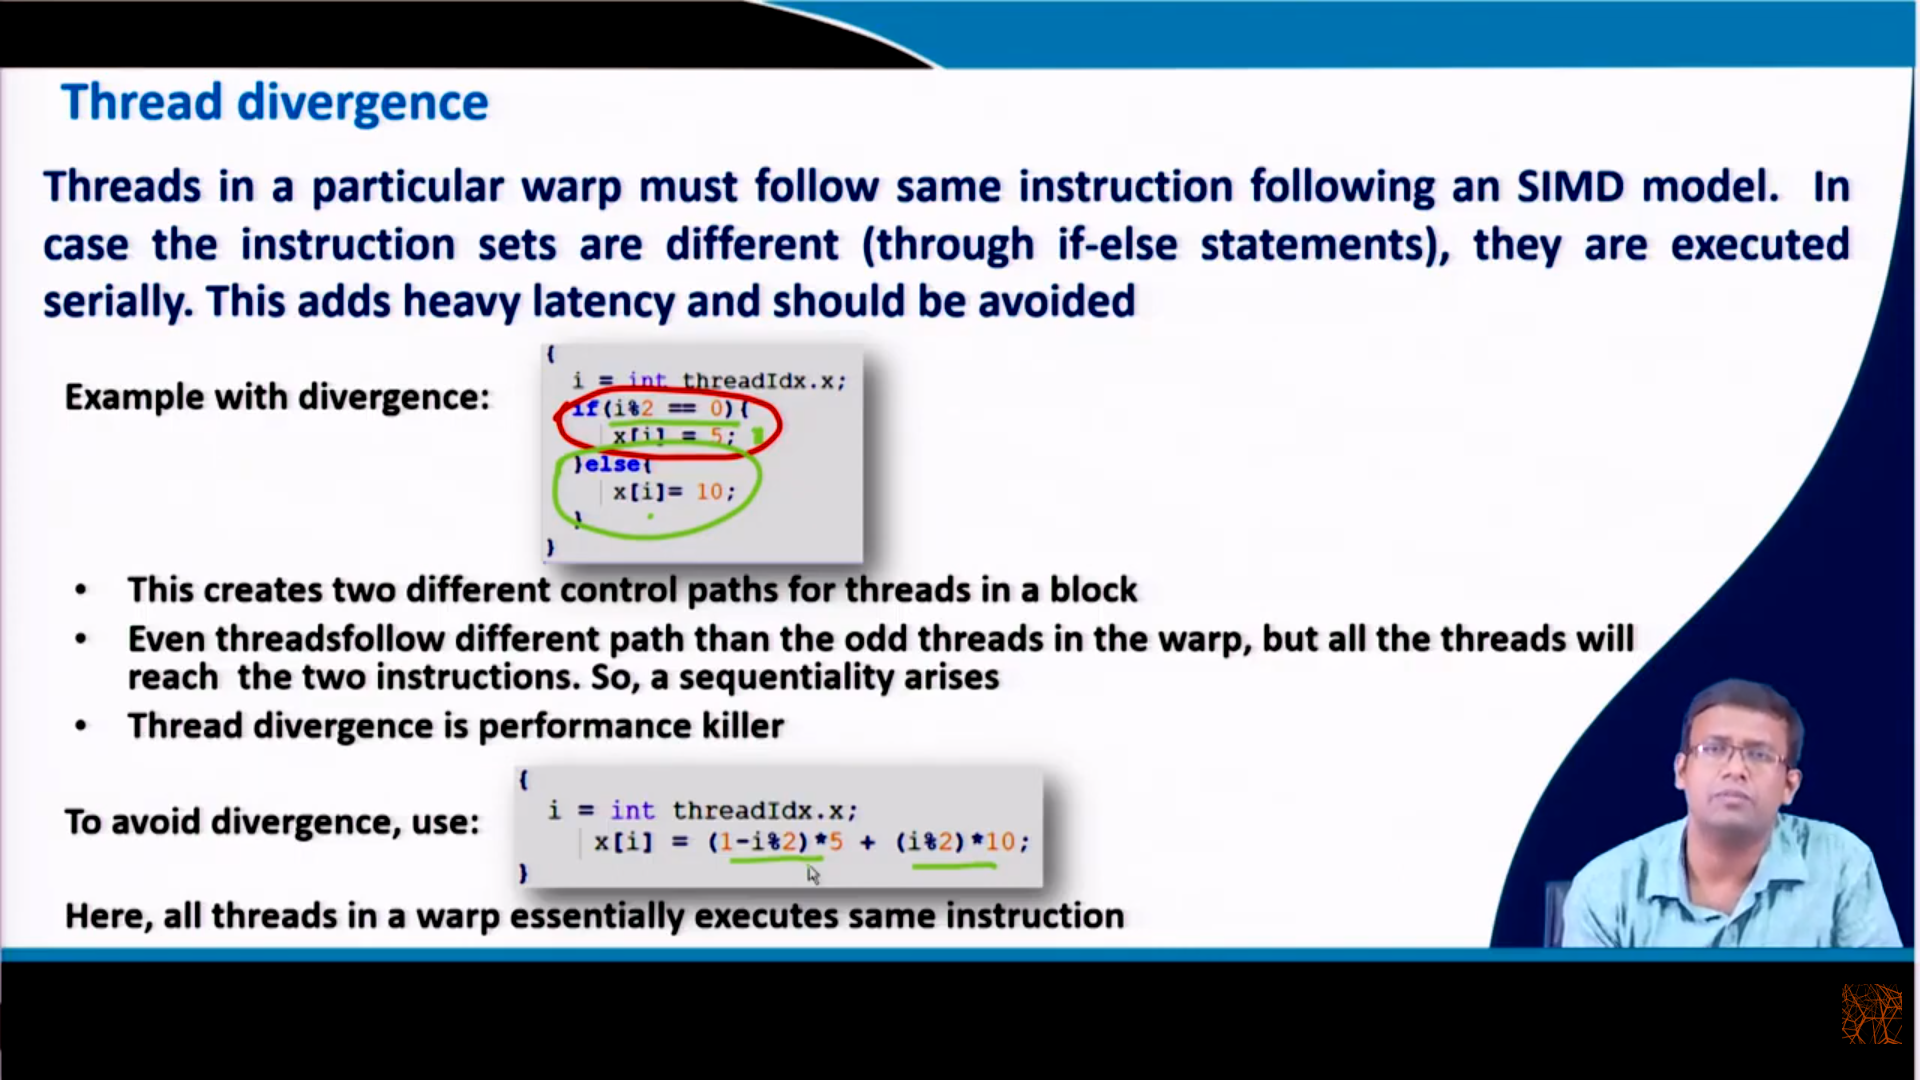

In [1]:
!pip install nvcc4jupyter

In [3]:
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpvlj27mf6".


In [4]:
!nvidia-smi

Fri Jan  2 06:47:52 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%%bash
cat << 'EOF' > cuda_prog.cu

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <cuda_runtime.h>

#define M 256  // Number of rows in A and C
#define K 512   // Number of columns in A and rows in B
#define N 256  // Number of columns in B and C
#define BLOCK_SIZE 32

// Example 3x2 @ 2x4 = 3x4 -> (M x K) @ (K x N) = (M x N)
// A = [[1, 2], 
//      [3, 4], 
//      [5, 6]]

// B = [[7, 8, 9, 10],
//      [11, 12, 13, 14]]

// C = A * B = [[1*7 + 2*11, 1*8 + 2*12, 1*9 + 2*13, 1*10 + 2*14],
//              [3*7 + 4*11, 3*8 + 4*12, 3*9 + 4*13, 3*10 + 4*14],
//              [5*7 + 6*11, 5*8 + 6*12, 5*9 + 6*13, 5*10 + 6*14]]

// C = [[29, 32, 35, 38],
//      [65, 72, 79, 86],
//      [101, 112, 123, 134]]


// CPU matrix multiplication
void matmul_cpu(float *A, float *B, float *C, int m, int k, int n) {
    for (int i = 0; i < m; i++) {
        for (int j = 0; j < n; j++) {
            float sum = 0.0f;
            for (int l = 0; l < k; l++) {
                sum += A[i * k + l] * B[l * n + j];
            }
            C[i * n + j] = sum;
        }
    }
}

// CUDA kernel for matrix multiplication
__global__ void matmul_gpu(float *A, float *B, float *C, int m, int k, int n) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < m && col < n) {
        float sum = 0.0f;
        for (int l = 0; l < k; l++) {
            sum += A[row * k + l] * B[l * n + col];
        }
        C[row * n + col] = sum;
    }
}

// Initialize matrix with random values
void init_matrix(float *mat, int rows, int cols) {
    for (int i = 0; i < rows * cols; i++) {
        mat[i] = (float)rand() / RAND_MAX;
    }
}

// Function to measure execution time
double get_time() {
    struct timespec ts;
    clock_gettime(CLOCK_MONOTONIC, &ts);
    return ts.tv_sec + ts.tv_nsec * 1e-9;
}

int main() {
    float *h_A, *h_B, *h_C_cpu, *h_C_gpu;
    float *d_A, *d_B, *d_C;
    int size_A = M * K * sizeof(float);
    int size_B = K * N * sizeof(float);
    int size_C = M * N * sizeof(float);

    // Allocate host memory
    h_A = (float*)malloc(size_A);
    h_B = (float*)malloc(size_B);
    h_C_cpu = (float*)malloc(size_C);
    h_C_gpu = (float*)malloc(size_C);

    // Initialize matrices
    srand(time(NULL));
    init_matrix(h_A, M, K);
    init_matrix(h_B, K, N);

    // Allocate device memory
    cudaMalloc(&d_A, size_A);
    cudaMalloc(&d_B, size_B);
    cudaMalloc(&d_C, size_C);

    // Copy data to device
    cudaMemcpy(d_A, h_A, size_A, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size_B, cudaMemcpyHostToDevice);

    // Define grid and block dimensions
    dim3 blockDim(BLOCK_SIZE, BLOCK_SIZE);
    dim3 gridDim((N + BLOCK_SIZE - 1) / BLOCK_SIZE, (M + BLOCK_SIZE - 1) / BLOCK_SIZE);

    // Warm-up runs
    printf("Performing warm-up runs...\n");
    for (int i = 0; i < 3; i++) {
        matmul_cpu(h_A, h_B, h_C_cpu, M, K, N);
        matmul_gpu<<<gridDim, blockDim>>>(d_A, d_B, d_C, M, K, N);
        cudaDeviceSynchronize();
    }

    // Benchmark CPU implementation
    printf("Benchmarking CPU implementation...\n");
    double cpu_total_time = 0.0;
    for (int i = 0; i < 20; i++) {
        double start_time = get_time();
        matmul_cpu(h_A, h_B, h_C_cpu, M, K, N);
        double end_time = get_time();
        cpu_total_time += end_time - start_time;
    }
    double cpu_avg_time = cpu_total_time / 20.0;

    // Benchmark GPU implementation
    printf("Benchmarking GPU implementation...\n");
    double gpu_total_time = 0.0;
    for (int i = 0; i < 20; i++) {
        double start_time = get_time();
        matmul_gpu<<<gridDim, blockDim>>>(d_A, d_B, d_C, M, K, N);
        cudaDeviceSynchronize();
        double end_time = get_time();
        gpu_total_time += end_time - start_time;
    }
    double gpu_avg_time = gpu_total_time / 20.0;

    // Print results
    printf("CPU average time: %f microseconds\n", (cpu_avg_time * 1e6f));
    printf("GPU average time: %f microseconds\n", (gpu_avg_time * 1e6f));
    printf("Speedup: %fx\n", cpu_avg_time / gpu_avg_time);

    // Free memory
    free(h_A);
    free(h_B);
    free(h_C_cpu);
    free(h_C_gpu);
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    return 0;
}


EOF


In [3]:
!nvcc cuda_prog.cu \
  -gencode arch=compute_75,code=sm_75 \
  -O2 \
  -lineinfo \
  -o cuda_prog

In [4]:
!./cuda_prog


Performing warm-up runs...
Benchmarking CPU implementation...
Benchmarking GPU implementation...
CPU average time: 42916.758450 microseconds
GPU average time: 264.062350 microseconds
Speedup: 162.525095x
